In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation

In [5]:
import math

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


### Carga de los datos:

In [42]:
name_f="international-airline-passengers.csv"

In [43]:
dataframe = pd.read_csv(name_f, sep=',', usecols=[1], engine='python', skipfooter=3)
dataframe[:] = dataframe[:].astype('float32') 
df_train, df_test = dataframe[0:96].values, dataframe[96:].values

Escalamiento de los datos:

In [44]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(df_train)
stream_train_scaled = scaler.transform(df_train)
stream_test_scaled = scaler.transform(df_test)

In [45]:
def create_dataset(dataset,lag=1):
    t_data = len(dataset)
    dataset = dataset.reshape(t_data)
    dataY = dataset[lag:]
    t_dataY = len(dataY)
    dataX = np.zeros((t_dataY, lag))
    for i in range(t_dataY):
        dataX[i] = dataset[i:lag+i]
    return np.array(dataX),np.array(dataY)

### Generar los conjuntos de entrenamiento y test:

In [46]:
lag = 3 #número de pasos de tiempo anteriores para usar como 
#variables de entrada para predecir el siguiente período de tiempo

In [47]:
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


**(H2) Determine el numero de bloques LSTM usando 5-fold Cross Validation.**

In [49]:
nb = range(4,13,2)
nb_len = len(nb)
trainX_len =len(trainX)
cross = cross_validation.KFold(trainX_len, nb_len)
cross_len =len(cross)
mse_cv = np.zeros(len(nb))
historiales = []

In [50]:
for bloque in range(nb_len):
    scores = np.zeros(cross_len)
    for i, (train, val) in enumerate(cross):
        model = Sequential()
        model.add(LSTM(output_dim=nb[bloque], input_dim=3, activation='tanh', inner_activation='sigmoid'))
        model.add(Dense(1))
        # Compilar modelo
        model.compile(loss='mean_squared_error', optimizer='adam')
        # Ajustar modelo
        hist = model.fit(trainX[train], trainY[train], nb_epoch=100, batch_size=1, verbose=0)
        historiales.append(hist)
        # Evaluar modelo
        trainPredict = model.predict(trainX[val])
        trainPredict = scaler.inverse_transform(trainPredict)
        trainYP = scaler.inverse_transform([trainY[val]])
        # RMSE
        scores[i] = math.sqrt(mean_squared_error(trainYP[0], trainPredict[:,0]))
    mse_cv[bloque] = scores.mean()
    print("El RMSE para un numero de %d bloques es %.4f" % (nb[bloque], mse_cv[bloque]))

El RMSE para un numero de 4 bloques es 24.4775
El RMSE para un numero de 6 bloques es 23.3565
El RMSE para un numero de 8 bloques es 23.6173
El RMSE para un numero de 10 bloques es 22.3093
El RMSE para un numero de 12 bloques es 23.2287


Como sabemos el overfitting es un problema comun en las redes recurrentes, ahora una tecnica para solucionar esto es contrar los parametros adecuados para evitarlo. Una tecnica comun para esto es Cross-validation, que sirve para el performance de estos parametros o mejor dicho los estimados asociados a estos parametros. En este caso podemos ver que el mejor numero de bloques es 10.

In [54]:
len(historiales)

25

Finalmente podemos ver una muestra las curvas de los erros obtenidos durante la estimación del mejor numero de bloques, los resultados son concistentes con los indicados. 

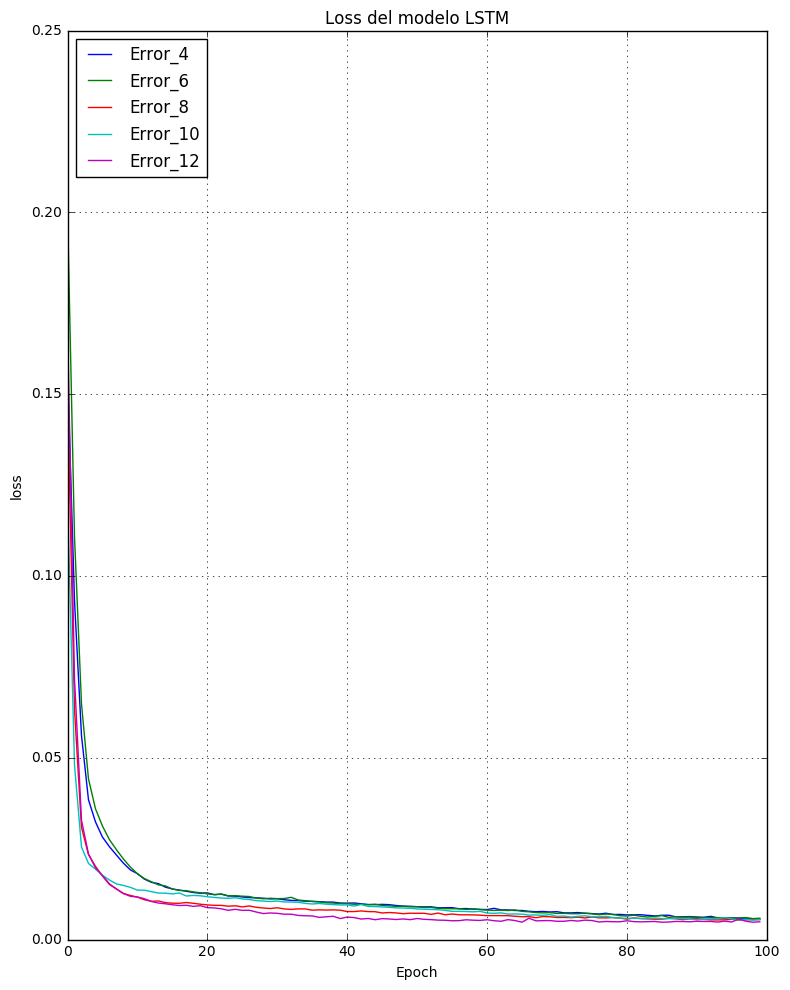

In [70]:
plt.figure(figsize=(8, 10))
#####
#plt.subplot(4, 2, 1)
plt.plot(historiales[2].epoch,historiales[2].history['loss']) 
plt.plot(historiales[7].epoch,historiales[7].history['loss'])  
plt.plot(historiales[12].epoch,historiales[12].history['loss']) 
plt.plot(historiales[17].epoch,historiales[17].history['loss']) 
plt.plot(historiales[22].epoch,historiales[22].history['loss']) 
plt.title('Loss del modelo LSTM')  
plt.ylabel('loss')  
plt.xlabel('Epoch')  
plt.legend(['Error_4','Error_6','Error_8','Error_10','Error_12'], loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()